In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from yellowbrick.features import manifold_embedding
from yellowbrick.features import pca_decomposition
import src.data.prepare as prep
import src.features as feat
import src.features.build_features
import src.data.seizures as seiz


C:\Users\thomasdo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import classification_report

In [3]:
name = '2016-10-13T1513'
data_df = prep.load_data(name, type='filtered', load_seizures=True)
raw = data_df['data']
real_seizures_df = data_df['real_seizures_df']
feature_df = feat.build_features.calc_features(
            raw, real_seizures_df, group_interval='1s')

C:\Users\thomasdo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\thomasdo\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
features = feat.build_features.get_feature_names() 
X = feat.get_X(feature_df, features)
print(X.shape)
y_true = feat.get_y(feature_df, 'is_seiz')

(1535, 10)


In [5]:
print(feature_df)

             sum      mean           var      amax  manhattan_length  \
275   292.866368  0.146433  6.565344e-07  0.148633          0.025069   
276   295.343475  0.147672  9.445549e-07  0.150255          0.022729   
277   297.076843  0.148538  5.290696e-07  0.150494          0.021538   
278   300.530107  0.150265  1.611578e-07  0.151283          0.022236   
279   299.389726  0.149695  5.073333e-07  0.151007          0.022674   
...          ...       ...           ...       ...               ...   
1805  289.750047  0.144875  1.238032e-06  0.147199          0.022948   
1806  293.752858  0.146876  3.529780e-07  0.148261          0.024475   
1807  294.836780  0.147418  8.010513e-07  0.149478          0.024974   
1808  293.821254  0.146911  7.600353e-07  0.148702          0.023114   
1809  297.859626  0.148930  8.438661e-07  0.150588          0.023520   

       entropy       rms  low_freq_value  mid_freq_value  high_freq_value  \
275   7.600887  0.146435        0.053420        0.006228  

In [6]:
param_grid = {
    'n_estimators': np.arange(5, 100, 5),#np.arange(1, 100).tolist(),#[5, 10, 15, 20],
    'max_depth': np.arange(1, 5).tolist(),
   # 'max_features': [5, 10, 15, 20]
             }


In [7]:
clf = RandomForestClassifier(n_estimators=20)


In [8]:
CV = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1)
CV.fit(X, y_true);


In [9]:
print(CV.best_params_)
print(CV.best_score_ )
clf_best = CV.best_estimator_

{'max_depth': 4, 'n_estimators': 15}
0.9583061889250815


In [10]:
scoring=['f1', 'accuracy']
scores = cross_validate(clf_best, X, y_true, cv=5, scoring=scoring)

In [11]:
scores

{'fit_time': array([0.02593422, 0.02493763, 0.02592969, 0.02493119, 0.02593064]),
 'score_time': array([0.00298786, 0.00199509, 0.00199819, 0.00299239, 0.00199628]),
 'test_f1': array([0.92708333, 0.9375    , 0.90909091, 0.94318182, 0.90607735]),
 'test_accuracy': array([0.95439739, 0.96091205, 0.94462541, 0.96742671, 0.94462541])}

In [12]:
y_pred = clf_best.predict(X)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['nonictal', 'ictal']))

              precision    recall  f1-score   support

    nonictal       0.99      0.96      0.98      1084
       ictal       0.92      0.98      0.95       451

    accuracy                           0.97      1535
   macro avg       0.95      0.97      0.96      1535
weighted avg       0.97      0.97      0.97      1535



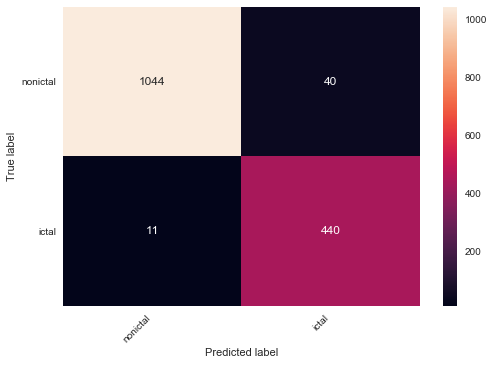

In [14]:
from src.visualization import metrics as metrics_viz
metrics_viz.plot_confusion_matrix(y_true, y_pred, classes=['nonictal', 'ictal'])

In [15]:
raw['is_seiz_pred'] = feat.build_features.add_y_pred_to_data(raw, y_pred)
algo_seizures_df = seiz.create_seizures_df_from_series(raw['is_seiz_pred'])
print(algo_seizures_df)
print(real_seizures_df)

        start             end          length
s_nr                                         
0    00:04:41 00:04:52.999500 00:00:11.999500
1    00:05:01 00:05:13.999500 00:00:12.999500
2    00:05:23 00:05:30.999500 00:00:07.999500
3    00:06:05 00:06:19.999500 00:00:14.999500
4    00:06:24 00:06:30.999500 00:00:06.999500
...       ...             ...             ...
78   00:28:50 00:28:50.999500 00:00:00.999500
79   00:29:09 00:29:10.999500 00:00:01.999500
80   00:29:19 00:29:32.999500 00:00:13.999500
81   00:29:34 00:29:34.999500 00:00:00.999500
82   00:29:43 00:29:50.999500 00:00:07.999500

[83 rows x 3 columns]
               start             end          length
s_nr                                                
0    00:04:41.001000 00:04:52.345000 00:00:11.344000
1    00:05:01.399000 00:05:13.409500 00:00:12.010500
2    00:05:23.175000 00:05:30.573000 00:00:07.398000
3    00:06:06.477000 00:06:19.516499 00:00:13.039499
4    00:06:25.462000 00:06:30.469000 00:00:05.007000
...     

In [16]:
%matplotlib auto
from src.visualization import seizures as seiz_viz
seiz_viz.plot_seizure_comparison(raw['yvalue'], real_seizures_df, algo_seizures_df)

Using matplotlib backend: Qt5Agg


In [17]:
import src.metrics
report = src.metrics.report('Test', 'Random_forest', algo_seizures_df, data_s= data_df)

In [18]:
print(report)

name                                                                      Test
algorithm_name                                                   Random_forest
algo_runtime_seconds                                                      None
real_seconds                                                              1535
real_count                                                                  68
algo_count                                                                  83
TP                                                                    0.249877
TN                                                                    0.685524
FN                                                                  0.00177264
FP                                                                   0.0628264
accuracy                                                              0.935401
sensitivity                                                           0.992956
specificity                                         

In [25]:
metrics_viz.plot_mismatches(real_seizures_df, algo_seizures_df)

       Seizure start  Seizure end
count      53.000000    53.000000
mean       -0.427443     0.570113
std         0.452211     0.431853
min        -1.696000    -0.028000
25%        -0.690500     0.296000
50%        -0.328500     0.493500
75%        -0.149500     0.792000
max         0.649000     1.908000
